In [1]:
import pandas as pd
import numpy as np
import scrapbook as sb

from matplotlib import cm
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.tight_layout()
plt.rcParams['figure.figsize'] = [20, 20]

%matplotlib inline

D:\software\anaconda\lib\site-packages\papermill\iorw.py:50: FutureWarning: pyarrow.HadoopFileSystem is deprecated as of 2.0.0, please use pyarrow.fs.HadoopFileSystem instead.
  from pyarrow import HadoopFileSystem


In [2]:
def cal_return(df):
    """
    calculate hourly log return
    """
    return np.log(df.close).diff()


def cal_vol(df, lookback=10):
    """
    calculate hourly volatility
    """
    o = df.open
    h = df.high
    l = df.low
    c = df.close
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co)+lo*(lo-co)
    close_vol = cc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    result[:lookback-1] = np.nan
    
    return result


def cal_max_drawdown(df):
    """
    calculate hourly max drawdown
    """
    hourly_drawdown = 1 - df.close / df.high.cummax()
    return hourly_drawdown.cummax()

In [3]:
def series_plot(data, ax=None):
    """
    time series plot
    """
    data.plot(ax=ax)
    
    start_of_days = data.between_time('00:00:00', '00:00:00').index.to_list()
    end_of_days = start_of_days[1:] + [data.index[-1]]
    colors = iter(cm.rainbow(np.linspace(0, 1, len(start_of_days))))
    
    for x, y in zip(start_of_days, end_of_days):
        color = next(colors)
        ax.axvspan(x, y, color=color, alpha=0.1)

#### Load data from database

In [4]:
token = 'BTC'
from_date = '2021-11-29'  # inclusive
to_date = '2021-12-13'    # exclusive
connection_string = "sqlite:///data/data.db"

In [5]:
# Parameters
from_date = "2021-12-06 00:00:00"
to_date = "2021-12-13 00:00:00"
token = "AVAX"
connection_string = "sqlite:///data/data.db"


In [6]:
prices = pd.read_sql(f'''
SELECT 
    * 
FROM ohlc 
WHERE 
    token = '{token}'
    AND ts >= '{from_date}'
    AND ts < '{to_date}'
''', connection_string)
prices['ts'] = pd.to_datetime(prices['ts'])

prices.set_index('ts', inplace=True)

#### Calculate Features

In [7]:
prices['return'] = cal_return(prices)
prices['volatility'] = cal_vol(prices)
prices['max_drawdown'] = cal_max_drawdown(prices)

#### Plot

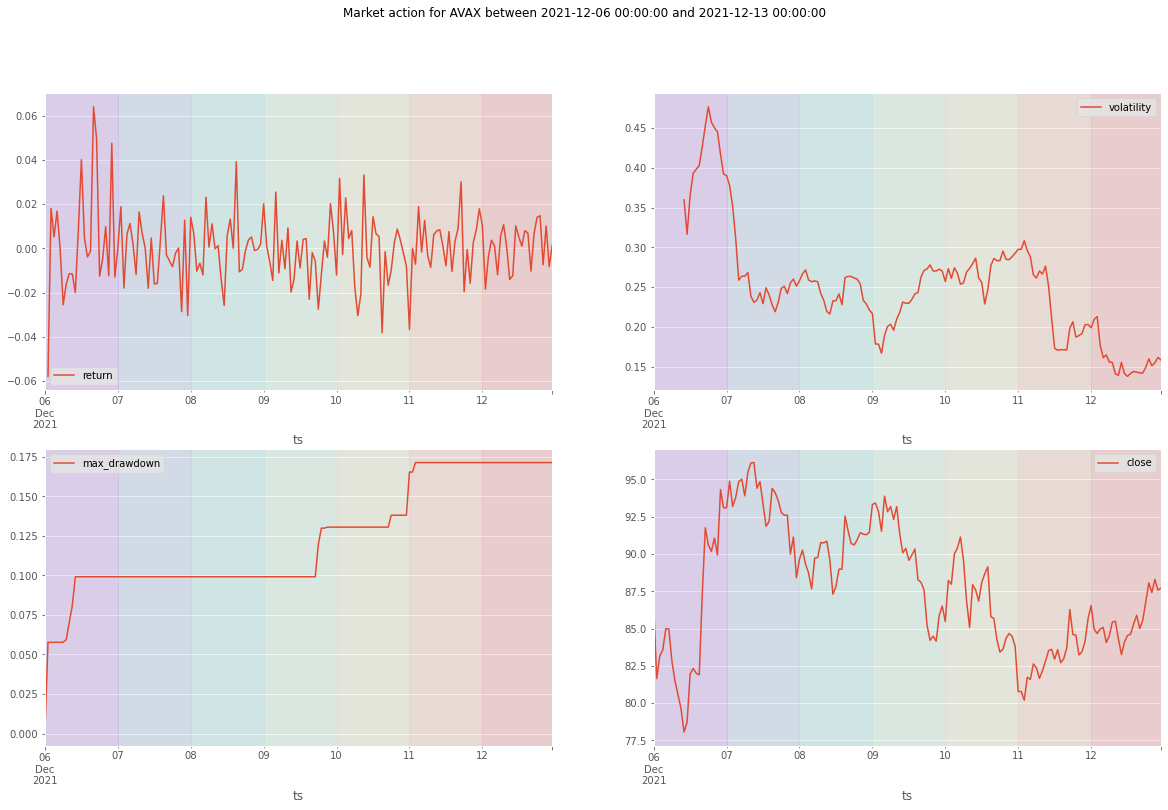

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))

series_plot(prices[['return']], ax=ax[0, 0])
series_plot(prices[['volatility']], ax=ax[0, 1])
series_plot(prices[['max_drawdown']], ax=ax[1, 0])
series_plot(prices[['close']], ax=ax[1, 1])
fig.suptitle(f'Market action for {token} between {from_date} and {to_date}')
plt.show()

#### save the data in notebook

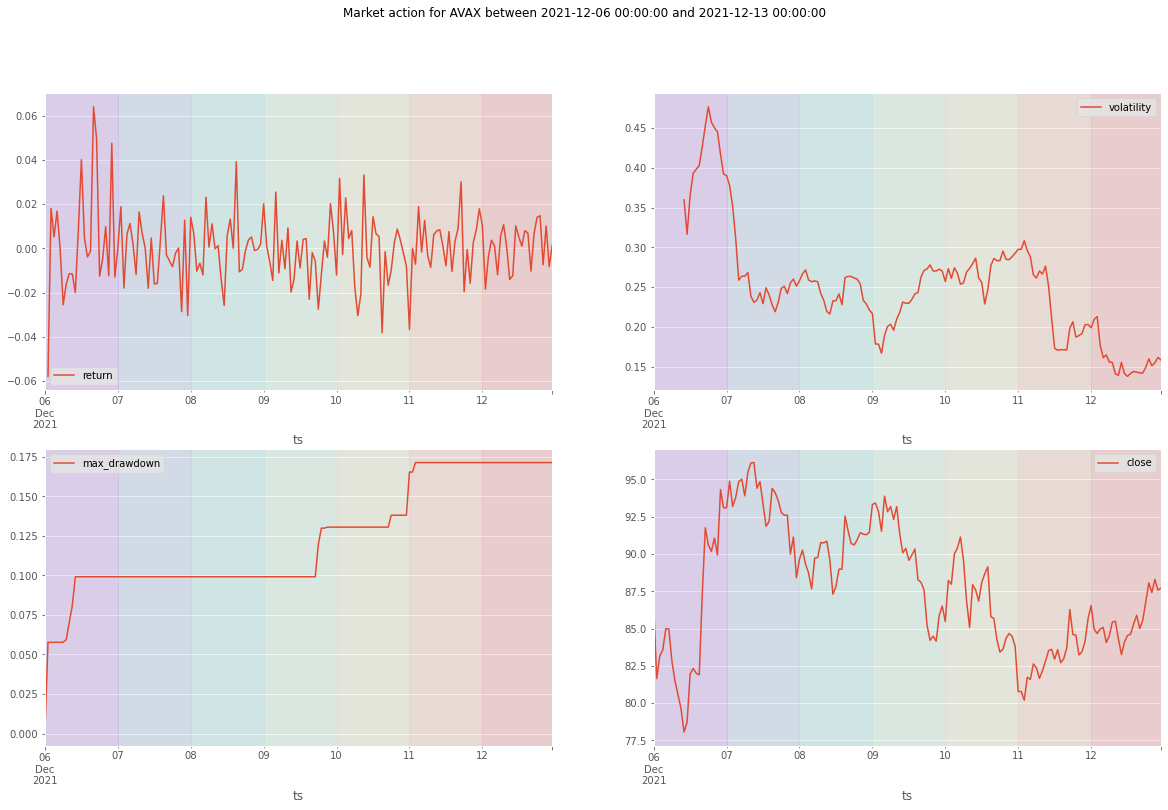

In [9]:
sb.glue('token', token)
sb.glue('from_date', from_date)
sb.glue('to_date', to_date)
sb.glue('prices', prices, encoder='pandas')
sb.glue('summary_plot', fig, encoder='display', display=True)